# Technical test for Descartes Data Scientist position
## Author: Nicolas Freychet

#### Objective:
To identify customer the most likely to make claims to the insurance. 

The target variable is "TARGET_FLAG".
There's also a "TARGET_AMT" variable given the explicite number of the claim. However here it will be ignore, as the goal is only to identify if there is a claim or not. 


#### Notes : 
There are 2 sets of data, one labelled "train" and one labelled "test". 

However, the "test" data contains only NaN for the target variable, thus it is considered as the final data to apply to the model to, but without possibility to evaluate the prediction.

The "train" data will be separated into training and testing samples to build up the model.



# Table of content <a class="anchor" id="TOC"></a>
* [Data and cleaning](#anchor-data)
* [Classification model tests](#anchor-classifmodel)
** [Decision Tree](#anchor-decisiontree)
** [Random Forest](#anchor-randomforest)
* [Prediction on test data](#anchor-testdata)

## 1-Data Exploration and cleaning<a class="anchor" id="anchor-data"></a>
[back to table of content](#TOC)

Section describing the data and dealing with potential missing values or useless variables...

In [1]:
## Packages:
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
## Read dataset and get some info (work only on Training data first):

df_train = pd.read_csv('train_auto.csv', index_col=0);
df_train = df_train.drop("TARGET_AMT", axis=1); #remove right away the unused target amount

# overview of the first rows:
display(df_train.head())

# get the number of NaN for each column:
print(df_train.isna().sum())


,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


TARGET_FLAG      0
KIDSDRIV         0
AGE              6
HOMEKIDS         0
YOJ            454
INCOME         445
PARENT1          0
HOME_VAL       464
MSTATUS          0
SEX              0
EDUCATION        0
JOB            526
TRAVTIME         0
CAR_USE          0
BLUEBOOK         0
TIF              0
CAR_TYPE         0
RED_CAR          0
OLDCLAIM         0
CLM_FREQ         0
REVOKED          0
MVR_PTS          0
CAR_AGE        510
URBANICITY       0
dtype: int64


In [3]:
# Some feature variables may not be pertinent, but as this cannot be discussed with other people here I will keep them all.

# Several columns have missing values.  
# I just remove them for simplier method.
df_train = df_train.dropna(axis=0);

# Display info after removing NaN:
df_train.info();


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6045 entries, 1 to 10302
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  6045 non-null   int64  
 1   KIDSDRIV     6045 non-null   int64  
 2   AGE          6045 non-null   float64
 3   HOMEKIDS     6045 non-null   int64  
 4   YOJ          6045 non-null   float64
 5   INCOME       6045 non-null   object 
 6   PARENT1      6045 non-null   object 
 7   HOME_VAL     6045 non-null   object 
 8   MSTATUS      6045 non-null   object 
 9   SEX          6045 non-null   object 
 10  EDUCATION    6045 non-null   object 
 11  JOB          6045 non-null   object 
 12  TRAVTIME     6045 non-null   int64  
 13  CAR_USE      6045 non-null   object 
 14  BLUEBOOK     6045 non-null   object 
 15  TIF          6045 non-null   int64  
 16  CAR_TYPE     6045 non-null   object 
 17  RED_CAR      6045 non-null   object 
 18  OLDCLAIM     6045 non-null   object 
 19  CLM_F

In [4]:
## Describe the Target variable : 'TARGET_FLAG'

# Get categories:
print('Target categories:', df_train['TARGET_FLAG'].unique());
print('Category counts: \n', df_train['TARGET_FLAG'].value_counts())

# The target is a discreet 1/0 variable, with a ratio of about 1/4 (customer who made a claim) - 3/4 (other customers)

# Convert target to str object:
df_train['TARGET_FLAG'] = df_train['TARGET_FLAG'].apply(str)


Target categories: [0 1]
Category counts: 
 0    4443
1    1602
Name: TARGET_FLAG, dtype: int64


In [5]:
## Check categorical variables:
display(df_train.select_dtypes(include=["object"]).head());

## Some variables must be converted to continuous variables as they correspond to a number: Income, Home_val, Bluebook, Oldclaim
list_col = ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']
for col in list_col: #convert each column to number by removing first '$' and ',' symbols
 df_train[col]=df_train[col].str.replace('$', '').str.replace(',','');
 df_train[col]=pd.to_numeric(df_train[col]);


,TARGET_FLAG,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,CAR_USE,BLUEBOOK,CAR_TYPE,RED_CAR,OLDCLAIM,REVOKED,URBANICITY
INDEX,,,,,,,,,,,,,,,
1,0,"$67,349",No,$0,z_No,M,PhD,Professional,Private,"$14,230",Minivan,yes,"$4,461",No,Highly Urban/ Urban
2,0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,Commercial,"$14,940",Minivan,yes,$0,No,Highly Urban/ Urban
4,0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,Private,"$4,010",z_SUV,no,"$38,690",No,Highly Urban/ Urban
7,1,"$125,301",Yes,$0,z_No,z_F,Bachelors,z_Blue Collar,Commercial,"$17,430",Sports Car,no,$0,No,Highly Urban/ Urban
12,1,"$62,978",No,$0,z_No,z_F,Bachelors,Clerical,Private,"$11,200",z_SUV,no,$0,No,Highly Urban/ Urban


<ipython-input-5-7917da51ddec>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_train[col]=df_train[col].str.replace('$', '').str.replace(',','');


In [6]:
## Many other categorical variables have two categories (yes/no, M/F,....) so they can be converted to numbers 1/0

# Print categories:
print('PARENT1:', df_train['PARENT1'].unique());
print('MSTATUS:', df_train['MSTATUS'].unique());
print('SEX:', df_train['SEX'].unique());
print('RED_CAR:', df_train['RED_CAR'].unique());
print('REVOKED:', df_train['REVOKED'].unique());
print('CAR_USE:', df_train['CAR_USE'].unique());
print('URBANICITY:', df_train['URBANICITY'].unique());

# Replace by 0/1:
df_train['PARENT1'] = df_train['PARENT1'].replace(['No', 'Yes'],[0, 1])
df_train['MSTATUS'] = df_train['MSTATUS'].replace(['z_No', 'Yes'],[0, 1])
df_train['SEX'] = df_train['SEX'].replace(['M', 'z_F'],[0, 1])
df_train['RED_CAR'] = df_train['RED_CAR'].replace(['no', 'yes'],[0, 1])
df_train['REVOKED'] = df_train['REVOKED'].replace(['No', 'Yes'],[0, 1])
df_train['CAR_USE'] = df_train['CAR_USE'].replace(['Private', 'Commercial'],[0, 1])
df_train['URBANICITY'] = df_train['URBANICITY'].replace(['Highly Urban/ Urban', 'z_Highly Rural/ Rural'],[0, 1])

# Check results:
display(df_train.head());


PARENT1: ['No' 'Yes']
MSTATUS: ['z_No' 'Yes']
SEX: ['M' 'z_F']
RED_CAR: ['yes' 'no']
REVOKED: ['No' 'Yes']
CAR_USE: ['Private' 'Commercial']
URBANICITY: ['Highly Urban/ Urban' 'z_Highly Rural/ Rural']


,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0,60.0,0,11.0,67349,0,0,0,0,...,14230,11,Minivan,1,4461,2,0,3,18.0,0
2,0,0,43.0,0,11.0,91449,0,257252,0,0,...,14940,1,Minivan,1,0,0,0,0,1.0,0
4,0,0,35.0,1,10.0,16039,0,124191,1,1,...,4010,4,z_SUV,0,38690,2,0,3,10.0,0
7,1,0,34.0,1,12.0,125301,1,0,0,1,...,17430,1,Sports Car,0,0,0,0,0,7.0,0
12,1,0,34.0,0,10.0,62978,0,0,0,1,...,11200,1,z_SUV,0,0,0,0,0,1.0,0


In [7]:
## For the last 3 categorical variables, use dichotomization:
Educ = pd.get_dummies(df_train['EDUCATION'], prefix='Educ');
Job = pd.get_dummies(df_train['JOB'], prefix='Job');
Car = pd.get_dummies(df_train['CAR_TYPE'], prefix='Car');

# Concact and drop old columns:
df_train = pd.concat([df_train,Educ,Job,Car],axis=1) ;
df_train = df_train.drop(['EDUCATION','JOB','CAR_TYPE'], axis=1);


In [8]:
# Final data: 
## all variables are int or float, except target
display(df_train.head());
display(df_train.info());

## Note : not sure the variable "HOMEKIDS" is useful as it only describe the number of kids, not the driving ones.


,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,Job_Manager,Job_Professional,Job_Student,Job_z_Blue Collar,Car_Minivan,Car_Panel Truck,Car_Pickup,Car_Sports Car,Car_Van,Car_z_SUV
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0,60.0,0,11.0,67349,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2,0,0,43.0,0,11.0,91449,0,257252,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,35.0,1,10.0,16039,0,124191,1,1,...,0,0,0,0,0,0,0,0,0,1
7,1,0,34.0,1,12.0,125301,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
12,1,0,34.0,0,10.0,62978,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6045 entries, 1 to 10302
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TARGET_FLAG         6045 non-null   object 
 1   KIDSDRIV            6045 non-null   int64  
 2   AGE                 6045 non-null   float64
 3   HOMEKIDS            6045 non-null   int64  
 4   YOJ                 6045 non-null   float64
 5   INCOME              6045 non-null   int64  
 6   PARENT1             6045 non-null   int64  
 7   HOME_VAL            6045 non-null   int64  
 8   MSTATUS             6045 non-null   int64  
 9   SEX                 6045 non-null   int64  
 10  TRAVTIME            6045 non-null   int64  
 11  CAR_USE             6045 non-null   int64  
 12  BLUEBOOK            6045 non-null   int64  
 13  TIF                 6045 non-null   int64  
 14  RED_CAR             6045 non-null   int64  
 15  OLDCLAIM            6045 non-null   int64  
 16  CLM_F

None

In [9]:
# Split data into target/features and then train/test samples:

y = df_train['TARGET_FLAG'];
X = df_train.drop('TARGET_FLAG', axis=1);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15) ; #split data with fixed random state


## 2-Classification model parametrisation<a class="anchor" id="anchor-classifmodel"></a>
[back to table of content](#TOC)


### Test 1 : Decision Tree<a class="anchor" id="anchor-decisiontree"></a>
Test with a decision tree first as it is easy to understand results and highlight the most important features.

In [12]:
## Packages
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [13]:
# Train model with default parameters, limit depth for interpretability:

clf = DecisionTreeClassifier(max_depth = 4);
clf = clf.fit(X_train, y_train);

# Apply to testing sampling:
y_pred = clf.predict(X_test);

# Evaluation with confusion matrix and classification report:
display(pd.crosstab(y_test, y_pred, rownames=["truth"], colnames=["predicted"]));
print(classification_report(y_test, y_pred));

## Not so great: Cannot detect efficiently the '1' (i.e. clients who will make a claim). 
# It may be because the data is unbalanced. 


predicted,0,1
truth,,
0,720,171
1,162,156


              precision    recall  f1-score   support

           0       0.82      0.81      0.81       891
           1       0.48      0.49      0.48       318

    accuracy                           0.72      1209
   macro avg       0.65      0.65      0.65      1209
weighted avg       0.73      0.72      0.73      1209



In [16]:
## Second test with re-balanced data:
from imblearn.under_sampling import RandomUnderSampler

#RandomUnderSampler
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

# Apply decision tree to balanced data
clf = DecisionTreeClassifier(max_depth = 4);
clf = clf.fit(X_ru, y_ru);
# Apply to testing sampling:
y_pred = clf.predict(X_test);

# Evaluation with confusion matrix and classification report:
display(pd.crosstab(y_test, y_pred, rownames=["truth"], colnames=["predicted"]));
print(classification_report(y_test, y_pred));

## This time the model can predict more accurately the "1" but also tends to predict to many 0 as 1. 
# If the goal is to be sure to identify potential claims, even if over estimate them, then that can be enough.

predicted,0,1
truth,,
0,534,357
1,72,246


              precision    recall  f1-score   support

           0       0.88      0.60      0.71       891
           1       0.41      0.77      0.53       318

    accuracy                           0.65      1209
   macro avg       0.64      0.69      0.62      1209
weighted avg       0.76      0.65      0.67      1209



In [23]:
## Check most important features to explain the decision tree classification (also see the decision tree figure below):

feats = {}
for feature, importance in zip(X_train.columns, clf.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})
importances.sort_values(by='Importance', ascending = False ).head(20)

# It seems that the place (urban or rural) most important factor (urban corresponding to more claims). 
# People with lower home values or people who previously did higher claims are also more likely to do claims.

,Importance
URBANICITY,0.352533
HOME_VAL,0.198469
OLDCLAIM,0.143456
Job_Manager,0.082700
Car_Minivan,0.072827
KIDSDRIV,0.064047
CAR_USE,0.020379
INCOME,0.020210
PARENT1,0.012651
Job_Student,0.011607


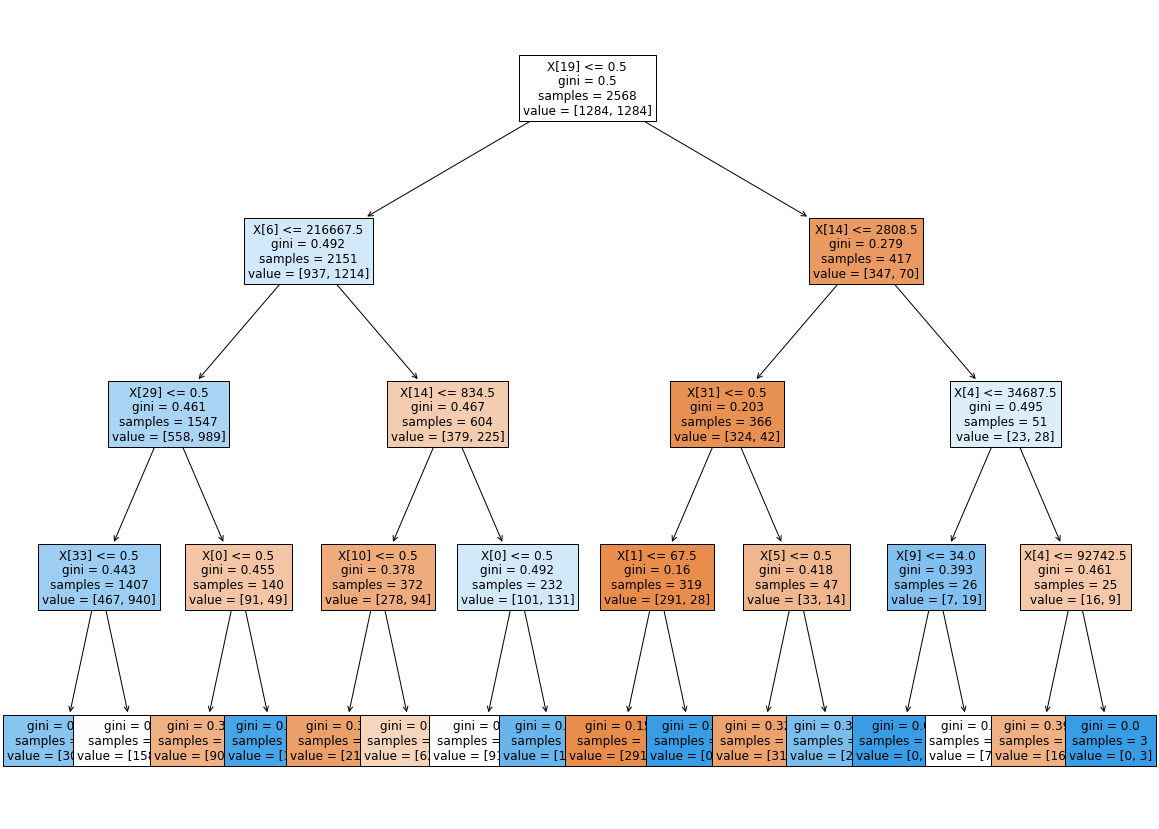

In [18]:
fig= plt.figure(figsize=(20,15))
tree.plot_tree(clf, filled=True,fontsize=12);


### Test 2: Random forest<a class="anchor" id="anchor-randomforest"></a>
This second model cannot be interpreted easily but could lead to better classification, so it is tested in second.

In [24]:
## Packages
from sklearn import ensemble


In [30]:
## Apply model to balanced data (keep similar depth to be more easily comparable with Decision Tree above)

clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 12, max_depth = 4)
clf.fit(X_ru, y_ru);

# Apply to testing sampling:
y_pred = clf.predict(X_test);

# Evaluation with confusion matrix and classification report:
display(pd.crosstab(y_test, y_pred, rownames=["truth"], colnames=["predicted"]));
print(classification_report(y_test, y_pred));

# This model improved a bit the recall of 0 while keeping similar scores for the 1.
# Thus there is less more chance to identify correctly the real potential claimers. 

predicted,0,1
truth,,
0,596,295
1,73,245


              precision    recall  f1-score   support

           0       0.89      0.67      0.76       891
           1       0.45      0.77      0.57       318

    accuracy                           0.70      1209
   macro avg       0.67      0.72      0.67      1209
weighted avg       0.78      0.70      0.71      1209



## 3-Apply model to sample to predict<a class="anchor" id="anchor-testdata"></a>
[back to table of content](#TOC)

In [31]:
# Get test data:
df_test = pd.read_csv('test_auto.csv', index_col=0);

# Drop Target columns as contains only Nan:
df_test = df_test.drop(['TARGET_FLAG','TARGET_AMT'],axis=1);

# Drop all other NaN:
df_test = df_test.dropna(axis=0);

# Convert some variables to number by removing first '$' and ',' symbols
list_col = ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']
for col in list_col: 
 df_test[col]=df_test[col].str.replace('$', '').str.replace(',','');
 df_test[col]=pd.to_numeric(df_test[col]);

# Replace by 0/1:
df_test['PARENT1'] = df_test['PARENT1'].replace(['No', 'Yes'],[0, 1])
df_test['MSTATUS'] = df_test['MSTATUS'].replace(['z_No', 'Yes'],[0, 1])
df_test['SEX'] = df_test['SEX'].replace(['M', 'z_F'],[0, 1])
df_test['RED_CAR'] = df_test['RED_CAR'].replace(['no', 'yes'],[0, 1])
df_test['REVOKED'] = df_test['REVOKED'].replace(['No', 'Yes'],[0, 1])
df_test['CAR_USE'] = df_test['CAR_USE'].replace(['Private', 'Commercial'],[0, 1])
df_test['URBANICITY'] = df_test['URBANICITY'].replace(['Highly Urban/ Urban', 'z_Highly Rural/ Rural'],[0, 1])

## For the last 3 categorical variables, use dichotomization:
Educ = pd.get_dummies(df_test['EDUCATION'], prefix='Educ');
Job = pd.get_dummies(df_test['JOB'], prefix='Job');
Car = pd.get_dummies(df_test['CAR_TYPE'], prefix='Car');

# Concact and drop old columns:
df_test = pd.concat([df_test,Educ,Job,Car],axis=1) ;
df_test = df_test.drop(['EDUCATION','JOB','CAR_TYPE'], axis=1);
    
# Display some info:
display(df_test.head());
display(df_test.info());

<ipython-input-31-0849afe7e2ff>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_test[col]=df_test[col].str.replace('$', '').str.replace(',','');


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,TRAVTIME,...,Job_Manager,Job_Professional,Job_Student,Job_z_Blue Collar,Car_Minivan,Car_Panel Truck,Car_Pickup,Car_Sports Car,Car_Van,Car_z_SUV
INDEX,,,,,,,,,,,,,,,,,,,,,
3,0,48.0,0,11.0,52881,0,0,0,0,26,...,1,0,0,0,0,0,0,0,1,0
9,1,40.0,1,11.0,50815,1,0,0,0,21,...,1,0,0,0,1,0,0,0,0,0
10,0,44.0,2,12.0,43486,1,0,0,1,30,...,0,0,0,1,0,0,0,0,0,1
21,0,59.0,0,12.0,87460,0,0,0,0,45,...,1,0,0,0,1,0,0,0,0,0
31,0,60.0,0,12.0,37940,0,182739,1,1,16,...,0,0,0,1,0,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1612 entries, 3 to 10300
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   KIDSDRIV            1612 non-null   int64  
 1   AGE                 1612 non-null   float64
 2   HOMEKIDS            1612 non-null   int64  
 3   YOJ                 1612 non-null   float64
 4   INCOME              1612 non-null   int64  
 5   PARENT1             1612 non-null   int64  
 6   HOME_VAL            1612 non-null   int64  
 7   MSTATUS             1612 non-null   int64  
 8   SEX                 1612 non-null   int64  
 9   TRAVTIME            1612 non-null   int64  
 10  CAR_USE             1612 non-null   int64  
 11  BLUEBOOK            1612 non-null   int64  
 12  TIF                 1612 non-null   int64  
 13  RED_CAR             1612 non-null   int64  
 14  OLDCLAIM            1612 non-null   int64  
 15  CLM_FREQ            1612 non-null   int64  
 16  REVOK

None

In [46]:
## Apply model: Random Forest
y_pred_test = clf.predict(df_test);

# Just as a test, count detected claimers:
from collections import Counter
Counter(y_pred_test) # in this data, the model detects 718 potential claimers


Counter({'0': 894, '1': 718})

In [50]:
## Export results as csv (as a simple single column here): 
y_pred_test=pd.DataFrame(y_pred_test);
y_pred_test.to_csv('TestClaimers-NicoFreychet.csv', index=False, header=False)